# Deep Q Network w/ tensorflow

Revised: YoungJun Kim 
(02-06-2018)

Deep Q network on GridWorld Problem

### 1. Import
- open AI gym
- TensorFlow >= 1.2.0
- gridworld.py (pre-defined game environment)

In [19]:
from __future__ import absolute_import, print_function, division
import numpy as np
import os, sys, random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load the Game environment: gridworld.py

- load environments of gridworld
- compose of pixels: Total 84x84x3
- move the blue square to green squares while avioiding red squares
- reward: +1 for reaching green square, -1 for reaching red square
- The position of the three blocks is randomized every episode.


- env = gameEnv(partial=False, size=5): 5x5 grid, fully observable environment defined
- state = env.reset(): returns new randomized environment for next episode
- [next_state, reward, done] = env.step(action): returns next_state, reward, and done value for given action

/Applications/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Applications/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


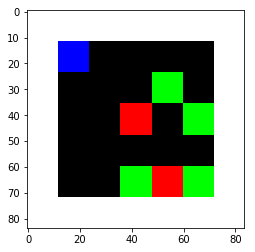

In [20]:
from gridworld import gameEnv

# open environment
env = gameEnv(partial=False,size=5)

# random setting current state
state = env.reset()

# visualize current state
env.visualize(state)

### 3. Implementing the network itself
### 1) Multi-layer CNN
- Start from State as a RGB-channel Image
- Convolution -> Re-LU Activation -> Max Pooling
- Feature Extraction

### 2) Fully-Connected Layer
- Fully connected Layer connecting Feature Vector output from CNN to Q-value
- Compute Q-value with simple Weight and Bias

### 3) Separate Target Network
- Target Q value for loss computation will be given from separate target network
- Target network will be updated slowly compared to primary network

### 4) Loss and Optimize
- Loss: Mean Squared Error between Target Q value and Predicted Q value
- Optimizer: Adam optimizer will be used

In [21]:
class Qnetwork():
    def __init__(self,h_size, Target=False):
        
        #h_size: size of final convolution layer connected to fc_layers
        
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        with tf.name_scope("{}".format("Target" if Target else "Primary")):
            with tf.name_scope("Feature_Extraction"):
                xavier_init = tf.contrib.layers.xavier_initializer()
                #get state as one-hot vector
                self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32, name="state")
                #reshape image to 84x84 with 3 channel
                self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])

                ## Value of each k_size, channel, stride is from original code
                ## Can be altered for better performance

                # channel num from input_state to final conv 4 (from 3 to h_size)
                channel_list = [3, 16, 32]

                # k_size / stride for max pooling
                k_size_list=[8, 4]
                stride_list = [4, 4]

                result = self.imageIn #rename for loop

                ## through 4 layers of convolution (valid padding) 
                # conv1 output: batch_size x 21 x 21 x 32
                # conv2 output: bath_size x 6 x 6 x 64
                # conv3 output: batch_size x 2 x 2 x 128
                # conv4 output: batch_size x 1 x 1 x 512 (final)

                for i in range(2):
                    j = i+1 # for next time_step

                    with tf.name_scope("conv_layer_{}".format(j)):

                        W = tf.Variable(name="conv_w", 
                                        initial_value=xavier_init([k_size_list[i], k_size_list[i], 
                                                                   channel_list[i], channel_list[j]]), 
                                        dtype=tf.float32)
                        b = tf.Variable(name="conv_b", 
                                        initial_value=xavier_init([channel_list[j]]), 
                                        dtype=tf.float32)

                        # convolution stage: SAME padding with W 
                        conv = tf.nn.conv2d(result, 
                                            W, 
                                            strides=[1, 1, 1, 1], 
                                            padding="SAME", 
                                            name="conv")

                        # add bias and activate with Re-LU function
                        h_out = tf.nn.relu(tf.nn.bias_add(conv, b), 
                                           name="h_out")

                        # max_pooling with pre-defined values
                        h_pool = tf.nn.max_pool(value=h_out, 
                                                ksize=[1, 2, 2, 1], 
                                                strides=[1, stride_list[i], stride_list[i], 1], 
                                                padding="SAME",
                                                name="pool")

                        result = h_pool # rename variables for loop
                        
                        tf.summary.histogram("conv_w_{}".format(j), W)
                        tf.summary.histogram("conv_b_{}".format(j), b)
                        tf.summary.histogram("h_pool_{}".format(j), h_pool)

                self.conv4 = result # rename for fc layer computation

            with tf.name_scope("Dueling_fc_layer"):
            # We take the output from the final convolutional layer 
            # and compute Q value with FC layer
            
                self.streamFeature = slim.flatten(self.conv4)
                
                self.W_1 = tf.Variable(xavier_init([h_size, 256]), name="weight_fc")
                self.b_1 = tf.Variable(xavier_init([256]), name="bias_fc")
                self.W_2 = tf.Variable(xavier_init([256, 4]), name="weight_fc")
                self.b_2 = tf.Variable(xavier_init([4]), name="bias_fc")
                
                z_1 = tf.add(tf.matmul(self.streamFeature,self.W_1), self.b_1)
                a_1 = tf.nn.relu(z_1)
                z_2 = tf.add(tf.matmul(a_1, self.W_2), self.b_2)
                self.Qout = z_2
                
                # predicted action out of Q-value
                self.predict = tf.argmax(self.Qout,1, name="predicted_action")

                # tensorboard summary
                tf.summary.histogram("FC_W1", self.W_1)
                tf.summary.histogram("FC_W2", self.W_2)
                tf.summary.histogram("Predicted_Q", self.Qout)

            if not Target:
                with tf.name_scope("Target_Network"):
                    #Below we obtain the loss by taking the sum of squares difference 
                    #between the target and prediction Q values.
                    self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32, name="target_Q")
                    self.actions = tf.placeholder(shape=[None],dtype=tf.int32, name="target_action")
                    self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)

                    # Q value from target network
                    self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
                    tf.summary.histogram("Target_Q", self.Q)

                with tf.name_scope("Optimizer"):
                    # MSE for calculating Loss between Target Q and Predicted Q
                    self.td_error = tf.square(self.targetQ - self.Q)
                    self.loss = tf.reduce_mean(self.td_error, name="Loss")

                    # Adam optimizer for updating the Model
                    self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001, name="optimizer")
                    self.updateModel = self.trainer.minimize(self.loss, name="update")
                    tf.summary.scalar("Loss", self.loss) 

### 5) Experience Replay
- Experience will be stored in buffer with limited size
- Each Experience is a tuple of 5 elements: [state, action, reward, next_state, done]
- Experience is added at every step
- If buffer size goes beyond the limit, old experiences will be deleted
- Expriences will be randomly sampled as a batch and given model network as an input

In [22]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        '''set buffers for experience
        Args: 
            buffer_size - how many experience to hold at given timestep'''
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        '''add experience to experience buffer'''
        
        # if buffer is full, delete the old experience
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
            
        # append [state, action, reward, next_state, done] tuple into experience buffer
        self.buffer.extend(experience)
            
    def sample(self,size):
        '''sample experience from buffer according to batch size'''
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

- This is a simple function to resize our game frames.

In [23]:
def processState(states):
    '''reshaping states into 1D tensor'''
    return np.reshape(states,[21168])

### 6) Slow Target Update
- Target Network will be updated slowly, for the stability of training
- Tau: parameter for updating values

In [24]:
def updateTargetGraph(tfVars,tau):
    '''Holds operation node for assigning Target values to Target network
    Args:
        tfVars - Variables for training(weights, bias...)
        Tau - rate for updating (low Tau value for slow updates)
    Return:
        op_holder - tf.assign() operation. input for updateTarget Function'''
    total_vars = len(tfVars)
    op_holder = []
    
    # for latter-half part of trainable variables (= for Target network variables)
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        # assigning tau*new_value+(1-tau)*old_values
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    '''run operation defined in updateTargetGraph function'''
    for op in op_holder:
        sess.run(op)

### 4. Graphing

### 1) Hyperparameter Setting

In [25]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
gamma = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action (epsilon)
endE = 0.1 #Final chance of random action (epsilon)
annealing_steps = 100. #How many steps of training to reduce startE to endE.
num_episodes = 50 #How many episodes of game environment to train network with.
pre_train_steps = 50 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model checkpoint & train model summary
h_size = 1152 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

### 2) Graphing Main Q network (Primary network) and Target Q network
- Build Main Q network and Target Q network Graphs
- Define saver and writer
- Assign function for Target Network update
- Set Experience Buffer
- Set Epsilon to anneal through episodes

In [26]:
#main_graph = tf.Graph()

#with main_graph.as_default():
tf.reset_default_graph()
#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

# set network for main model
mainQN = Qnetwork(h_size)

Tensor("Primary/Feature_Extraction/conv_layer_1/pool:0", shape=(?, 21, 21, 16), dtype=float32)
Tensor("Primary/Feature_Extraction/conv_layer_2/pool:0", shape=(?, 6, 6, 32), dtype=float32)


In [27]:
# set network for target Q-value computation
targetQN = Qnetwork(h_size, True)

# initialize the varibales
init = tf.global_variables_initializer()

# saver for model
saver = tf.train.Saver()

writer = tf.summary.FileWriter(logdir=path)
summary = tf.summary.merge_all()

# get all the trainable variables
trainables = tf.trainable_variables()

# update operation for target graph, ratio for update is defined as tau
targetOps = updateTargetGraph(trainables,tau)

# set default buffer to hold experiences of episodes
myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
reward_List = []

print("Graphing Done!")

Tensor("Target/Feature_Extraction/conv_layer_1/pool:0", shape=(?, 21, 21, 16), dtype=float32)
Tensor("Target/Feature_Extraction/conv_layer_2/pool:0", shape=(?, 6, 6, 32), dtype=float32)
Graphing Done!


### 5. Training the Network
- Set Load option
- Epsilon anneal through episodes
- Train Network after pre-training - search the environment before actual training starts
- add experience to buffer
- Predict action from Main Q and Target Q
- Calculate Target Q
- Update Main Q parameters
- Update Target Q parameters (slowly)
- Update buffer
- Save and Write Current Model

In [30]:
with tf.Session() as sess:
    # initialize
    sess.run(init)
    writer.add_graph(sess.graph)
    global_step = 0
    
    # load model if checkpoint exists
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        print("Initializing all variables...")
        sess.run(tf.global_variables_initializer())

    # training
    for i in range(num_episodes):
    
        if i % 10 == 0:
            print("\rEpisode {}/{}.".format(i, num_episodes), end="")
            sys.stdout.flush()

        # re-assign current epsiode buffer
        episodeBuffer = experience_buffer()
        
        # Reset environment and get first new observation
        state = env.reset()
        state = processState(state)
        done = False
        reward_All = 0
        j = 0
        
        #The Q-Network
        #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
        while j < max_epLength: 
            j+=1
            global_step+=1
            
            # Epsilon-Greedy Approach
            # Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or global_step < pre_train_steps:
                action = np.random.randint(0,4)
            else:
                action = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[state]})[0]
            
            # get next state, reward, and done from environment
            next_state, reward, done = env.step(action)
            next_state = processState(next_state)
            
            
            #Save the experience to our episode buffer.
            episodeBuffer.add(np.reshape(np.array([state, action, reward, next_state, done]),[1,5])) 
            
            # annealing epsilon
            if global_step > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                # every update_freq steps, do training from experience buffer
                if global_step % (update_freq) == 0:
                    
                    #Get a random batch of experiences.
                    trainBatch = myBuffer.sample(batch_size) 
                    
                    #Below we perform the Double-DQN update to the target Q-values
                    
                    # predict action of next state (primary)
                    predicted_action = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    # predict Q value of next state (target)
                    target_Q = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    
                    # check if episode ended
                    # if end, set future discounted reward to 0
                    # as each episode has no end, end_multiplier = 1
                    end_multiplier = -(trainBatch[:,4] - 1)
                    
                    # get Q value of predicted Action
                    nextQ = np.max(target_Q)
                    
                    # calculate Target Q value with Bellman Equation
                    # reward + discounted next_state Qvalue
                    targetQ = trainBatch[:,2] + (gamma * nextQ * end_multiplier)

                    # Update the network with our target values.
                    _, curr_sum = sess.run([mainQN.updateModel, summary],\
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, 
                                   mainQN.actions:trainBatch[:,1], targetQN.scalarInput:np.vstack(trainBatch[:,0])})
                    
                    # update main QN summary
                    writer.add_summary(curr_sum, global_step=global_step)
                    
                    # Update the target network toward the primary network.
                    # assign updated value from Main Q with low update rate
                    updateTarget(targetOps,sess)
            
            # save reward
            reward_All += reward
            # move to the next state
            state = next_state
            
            
            # if episode is done, break the loop
            if done == True:
                break
        
        # update experience buffer of the whole episode to main buffer
        myBuffer.add(episodeBuffer.buffer)
        
        jList.append(j)
        reward_List.append(reward_All)
        
        #Periodically save the model. 
        if (i+1) % 10 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(reward_List) % 2 == 0:
            print("Total Steps:{}, Mean Rewards:{}, Epsilon:{:,.2f}".format(global_step,np.mean(reward_List[-10:]), e))
    
    # save at the last episode
    saver.save(sess, os.path.join(logdir, "model.ckpt"), global_step=global_step)
    
print("Percent of succesful episodes: " + str(sum(reward_List)/num_episodes) + "%")

Initializing all variables...
Episode 0/50.Total Steps:50, Mean Rewards:1.4, Epsilon:0.10


/Applications/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Applications/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Total Steps:150, Mean Rewards:1.4, Epsilon:0.10
Total Steps:250, Mean Rewards:1.5, Epsilon:0.10
Total Steps:350, Mean Rewards:1.5, Epsilon:0.10
Total Steps:450, Mean Rewards:1.2, Epsilon:0.10
Saved Model
Episode 10/50.Total Steps:550, Mean Rewards:1.2, Epsilon:0.10
Total Steps:650, Mean Rewards:1.0, Epsilon:0.10
Total Steps:750, Mean Rewards:0.9, Epsilon:0.10
Total Steps:850, Mean Rewards:0.8, Epsilon:0.10
Total Steps:950, Mean Rewards:0.7, Epsilon:0.10
Saved Model
Episode 20/50.Total Steps:1050, Mean Rewards:0.8, Epsilon:0.10
Total Steps:1150, Mean Rewards:0.9, Epsilon:0.10
Total Steps:1250, Mean Rewards:0.7, Epsilon:0.10
Total Steps:1350, Mean Rewards:0.7, Epsilon:0.10
Total Steps:1450, Mean Rewards:0.7, Epsilon:0.10
Saved Model
Episode 30/50.Total Steps:1550, Mean Rewards:0.4, Epsilon:0.10
Total Steps:1650, Mean Rewards:0.2, Epsilon:0.10
Total Steps:1750, Mean Rewards:0.3, Epsilon:0.10
Total Steps:1850, Mean Rewards:0.2, Epsilon:0.10


KeyboardInterrupt: 

- Reward Result Checking

In [ ]:
rMat = np.resize(np.array(reward_List),[len(reward_List)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)

### 6. Simulation
- Reset game environment
- Follow greedily according to the action from trained Model

/Applications/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Applications/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


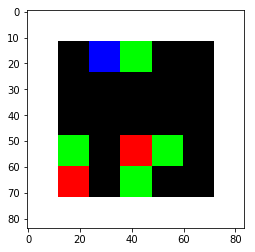

In [16]:
# set new random game environment
state = env.reset()
reward_all = 0
# show grid layout
env.visualize(state)

In [17]:
## simulation ##
# move to next step

def next_state(game_env, state, Q, epsilon=0, visulaize=False):
    '''move to next state
        Args:
            game_env: environment for game
            state: current state as 84x84x3 image vector
            Q: main Q network
            epsilon: for epsilon greedy approach (default=0)
            visualize: print State after action is applied as an image(default: false)
        Returns:
            next_state: state after desired action is taken'''

    with tf.Session() as sess:

        # load from checkpoint
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)

        # process initial state, done and step
        state = processState(state)
        done = False
        j = 0
        
        # get action from main Q network
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,4)
        else:
            action = sess.run(Q.predict,feed_dict={Q.scalarInput:[state]})[0]
        
        # move to next state, check reward and if finished
        next_state, reward, done = game_env.step(action)

        # print next action
        possible_action = ["up","down","left","right"]
        print("Action:{}, Reward:{}".format(possible_action[action], reward))
        
        # show changed state
        if visulaize:
            env.visualize(next_state)  
        
        # if finished, print the result
        if done == True:
            if reward > 0:
                print("You Win!")
            else:
                print("You Lose!")
            
        return next_state, reward

INFO:tensorflow:Restoring parameters from ./double_dqn/model-0.ckpt
Action:down, Reward:1.0
Total Reward 1.0


/Applications/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Applications/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


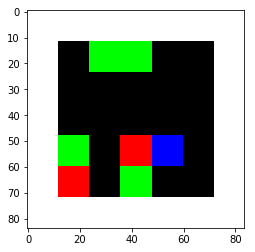

In [22]:
state, reward = next_state(env, state, targetQN, 0, True)
reward_all += reward
print("Total Reward", reward_all)

In [23]:
def performance(game_env, Q, n, epsilon):
    '''Args:
            game_evnv: environment for game
            Q: Q network
            n: number of episodes to look
            epsilon: for epsilon greedy approach (default=0)
        Return:
            rewards_list: total cumulative reward of each episode as a list'''
    
    rewards_list = []
    state = env.reset()
    
    j = 0
    with tf.Session() as sess:

        # load from checkpoint
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)

        # process initial state, done and step
        state = processState(state)
        done = False
        
        for i in range(n):
            
            reward_total = 0
            j = 0
            
            while j<50:
                
                j+=1

                # get action from main Q network
                if np.random.rand(1) < epsilon:
                    action = np.random.randint(0,4)
                else:
                    action = sess.run(Q.predict,feed_dict={Q.scalarInput:[state]})[0]

                # move to next state, check reward and if finished
                next_state, reward, done = game_env.step(action)

                reward_total += reward
                state = processState(next_state)
                
                if done == True:
                    break
                    
            rewards_list.append(reward_total)
            
            state = env.reset()
            state = processState(state)
            
    return rewards_list



In [25]:
RL = performance(env, targetQN, 50, 0)
print(np.mean(RL))

INFO:tensorflow:Restoring parameters from ./double_dqn/model-0.ckpt


/Applications/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Applications/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


0.24


### Reference

In this iPython notebook I implement a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to solve a navigation task in a basic grid world. To learn more, read here: https://medium.com/p/8438a3e2b8df

For more reinforcment learning tutorials, see:
https://github.com/awjuliani/DeepRL-Agents